# Data exploration and cleaning

This notebook is used to explore and clean the music data we are using for our project.

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import string
from colorutils import Color
import getpass
import random


%load_ext blackcellmagic

## Loading the original raw data

he dataset we are going to use consists of a [subset](https://github.com/kevinschaich/billboard) of the top 100 songs from 1950 to 2015. 

In [2]:
data_folder = "data/years/"

file_list = [
    f
    for f in listdir(data_folder)
    if isfile(join(data_folder, f)) and f.endswith(".json")
]

dfs = []  # an empty list to store the data frames
for file in file_list:
    path = data_folder + file
    data = pd.read_json(path)  # read data frame from json file
    dfs.append(data)  # append the data frame to the list

music_data = pd.concat(
    dfs, ignore_index=True
)  # concatenate all the data frames in the list.

In [3]:
print(f"There are {len(music_data)} songs.")

There are 4028 songs.


## Data exploration

### Basic statistics

In [4]:
music_data.groupby("year")[["lyrics"]].count().describe()

,lyrics
count,66.000000
mean,61.030303
std,20.331082
min,6.000000
25%,54.250000
50%,68.000000
75%,76.000000
max,82.000000


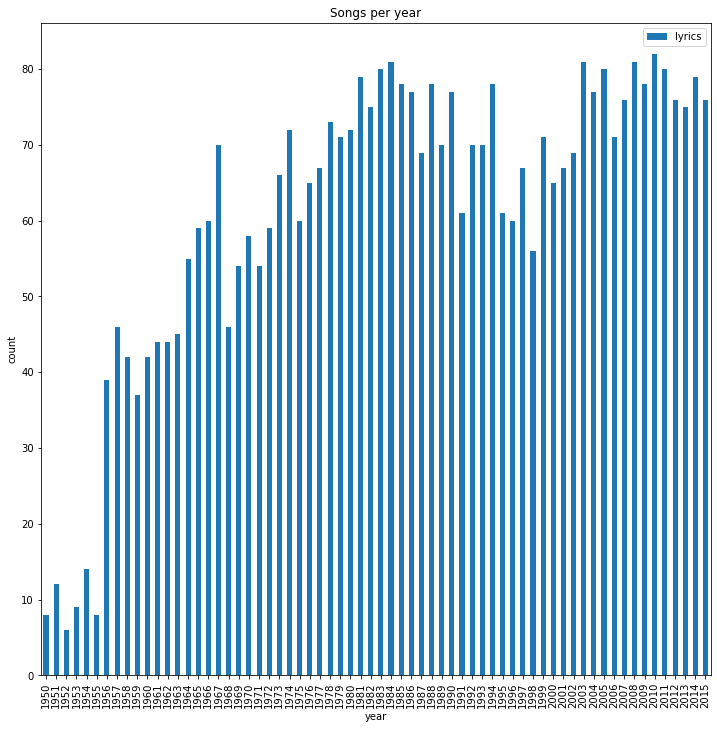

In [5]:
music_data.groupby("year")[["lyrics"]].count().plot(
    kind="bar", figsize=(12, 12), title="Songs per year"
)
plt.ylabel("count")
plt.xlabel("year")
plt.show()

We see that we do have only a small sample of the top 100 for the first 6 years, for the rest we have at least 40 percent and evn more for recent years.



In [6]:
print(
    f"There are {len(set([element for list_ in list(music_data.tags) for element in list_]))} tags."
)

There are 966 tags.


In [7]:
print(f"There are {len(music_data['artist'].drop_duplicates())} artists.")

There are 1308 artists.


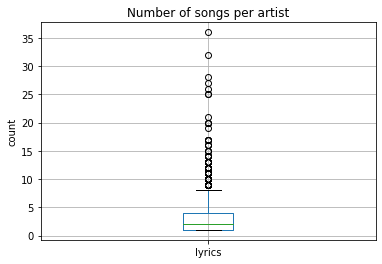

In [8]:
music_data.groupby("artist")[["lyrics"]].count().boxplot()
plt.title("Number of songs per artist")
plt.ylabel("count")
# plt.yscale('log')
plt.show()

### Sentiment analysis

The means for the negative, positive and neutral songs are respectively: 0.0743, 0.156 and 0.769.


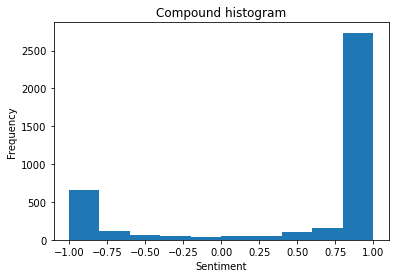

In [9]:
neg_mean = music_data.sentiment.map(lambda dic: dic["neg"]).mean()
pos_mean = music_data.sentiment.map(lambda dic: dic["pos"]).mean()
neutral_mean = music_data.sentiment.map(lambda dic: dic["neu"]).mean()
print(
    f"The means for the negative, positive and neutral songs are respectively: {neg_mean:.3}, {pos_mean:.3} and {neutral_mean:.3}."
)
music_data.sentiment.map(lambda dic: dic["compound"]).plot(kind="hist")
plt.title("Compound histogram")
plt.xlabel("Sentiment")
plt.show()

## Color detection

We will try using a set of colors to identify in the lyrics

In [10]:
set_colors = set(
    [
        "white",
        "black",
        "yellow",
        "green",
        "purple",
        "brown",
        "pink",
        "red",
        "blue",
        "maroon",
        "salmon",
        "coral",
        "orange",
        "gold",
        "silver",
        "lime",
        "turquoise",
        "cyan",
        "navy",
        "indigo",
        "magenta",
        "beige",
        "tan",
        "gray",
    ]
)

In [11]:
print(f"The set of colors contains {len(set_colors)} colors.")

The set of colors contains 24 colors.


In [12]:
music_data["intersection_colors_title"] = (
    music_data["title"]
    .str.lower()
    .map(
        lambda title: set(
            title.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(set_colors)
    )
)
music_data["intersection_colors_lyrics"] = (
    music_data["lyrics"]
    .str.lower()
    .map(
        lambda lyrics: set(
            lyrics.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(set_colors)
    )
)

In [13]:
colored_songs = music_data[music_data["intersection_colors_lyrics"] != set()]

colored_titles = music_data[music_data["intersection_colors_title"] != set()]

In [14]:
print(f"There are {len(colored_titles)} songs with colors in their lyrics.")

print(f"There are {len(colored_songs)} songs with colors in their lyrics.")

There are 59 songs with colors in their lyrics.
There are 779 songs with colors in their lyrics.


We decide to use the lyrics to have enough data.

In [15]:
color_counts = (
    pd.DataFrame(
        [
            color
            for colors_list in list(
                colored_songs["intersection_colors_lyrics"].map(lambda set_: list(set_))
            )
            for color in colors_list
        ],
        columns=["color"],
    )
    .reset_index()
    .groupby("color")
    .count()
    .rename(columns={"index": "count"})
)

We can now plot the distribution of colors we have detected:

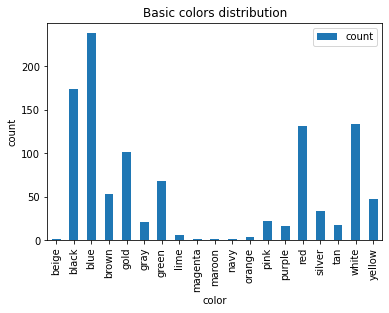

In [16]:
color_counts.plot(kind="bar")
plt.title("Basic colors distribution")
plt.ylabel("count")
plt.show()

In [17]:
selected_columns = [
    "lyrics",
    "tags",
    "pos",
    "year",
    "title",
    "artist",
    "intersection_colors_lyrics",
]

final_df = colored_songs[selected_columns].copy()
final_df["intersection_colors_lyrics"] = final_df["intersection_colors_lyrics"].apply(
    lambda x: list(x)
)
final_df = final_df.explode("intersection_colors_lyrics").rename(
    columns={"intersection_colors_lyrics": "color"}
)
final_df

,lyrics,tags,pos,year,title,artist,color
12,I tried so hard my dear to show that you're my...,"[american, jazz, pop]",7,1951,"Cold, Cold Heart",Tony Bennett,blue
15,If ever a devil was born\nWithout a pair of ho...,[death by heart failure],11,1951,Jezebel,Frankie Laine,blue
20,if you loved me half as much as i love you\nyo...,"[american, jazz, pop, vocal jazz]",6,1952,Half As Much,Rosemary Clooney,blue
30,Pretend you're happy when you're blue\nIt isn'...,"[american, death by lung cancer, easy listenin...",13,1953,Pretend,Nat King Cole,blue
33,"Tell me story, tell me story\nTell me story, r...",[death by heart failure],23,1953,Tell Me A Story,Frankie Laine,red
...,...,...,...,...,...,...,...
4007,"Chris Brown\nBaby, is you drunk cause you had ...",[meek mill],69,2015,All Eyes On You,Meek Mill,brown
4009,I was scared of dentists and the dark\nI was s...,"[alternative rock, indie folk, indie pop]",71,2015,Riptide,Vance Joy,green
4012,I found myself dreaming of\nSilver and gold\nL...,"[a filk artist, blue-eyed soul, dance-pop, doo...",76,2015,Like I'm Gonna Lose You,Meghan Trainor,gold
4012,I found myself dreaming of\nSilver and gold\nL...,"[a filk artist, blue-eyed soul, dance-pop, doo...",76,2015,Like I'm Gonna Lose You,Meghan Trainor,silver


In order to have a nicer looking visualization, we add some perturbations to the detected colors. This is done in order to avoid having big chunks of the visualization having exactly the same rgb.

In [18]:
def randomize_rgb(rgb, perturbation=20):
    new_rgb = []
    for val in rgb:
        new_rgb.append(
            max(0, min(val + random.randint(-perturbation, perturbation), 255))
        )
    return "rgb" + str(tuple(new_rgb))

In [19]:
final_df["hue_0"] = final_df["color"].apply(lambda c: Color(web=c).hsv[0])
final_df["hue_1"] = final_df["color"].apply(lambda c: Color(web=c).hsv[1])
final_df["hue_2"] = final_df["color"].apply(lambda c: Color(web=c).hsv[2])
final_df["rgb"] = final_df["color"].apply(lambda c: Color(web=c).rgb)
final_df["random_rgb"] = final_df["rgb"].apply(lambda c: randomize_rgb(c))

In [20]:
final_df = final_df.sort_values(["hue_0", "hue_1", "hue_2"])

In [21]:
final_df.head()

,lyrics,tags,pos,year,title,artist,color,hue_0,hue_1,hue_2,rgb,random_rgb
33,"Tell me story, tell me story\nTell me story, r...",[death by heart failure],23,1953,Tell Me A Story,Frankie Laine,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(0, 0, 0)"
57,"Well, since my baby left me\nIn the fiery plac...","[american, blue-eyed soul, blues, christmas mu...",1,1956,Heartbreak Hotel,Elvis Presley,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(12, 0, 0)"
112,"Bah, bah, bah, but\nBah, bah, bah, but\nBah, b...","[all-time greatest hits, death by airplane]",25,1957,A Teenager's Romance,Ricky Nelson,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(14, 10, 12)"
225,You can shake an apple off an apple tree\nShak...,"[american, blue-eyed soul, blues, christmas mu...",9,1960,Stuck On You,Elvis Presley,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(0, 0, 0)"
287,There is a rose in Spanish Harlem\nA red rose ...,"[classic pop and rock, funk, jazz pop, pop, po...",64,1961,Spanish Harlem,Ben E. King,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(4, 0, 18)"


### Adding the spotify links

Get the above from your [Spotify Dashboard](https://developer.spotify.com/dashboard/). The steps to do it are presented [here](https://developer.spotify.com/documentation/general/guides/app-settings/).

The goal is to have the Spotify URI in order to be able to have a Spotify play button.

We first automaticall try to fetch as much data as posible using the song names and artists.

In [22]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials  # To access authorised Spotify data

In [ ]:
spotify_client_id = getpass.getpass()

In [ ]:
spotify_client_secret = getpass.getpass()

In [25]:
client_credentials_manager = SpotifyClientCredentials(
    client_id=spotify_client_id, client_secret=spotify_client_secret
)
sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)  # spotify object to access API

An example on how to use the spotify request manager.

In [26]:
name = "Kanye West, Homecoming"  # chosen artist
result = sp.search(name)  # search query
result["tracks"]["items"][0]["artists"]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5K4W6rqBFWDnAN6FQUkS6x'},
  'href': 'https://api.spotify.com/v1/artists/5K4W6rqBFWDnAN6FQUkS6x',
  'id': '5K4W6rqBFWDnAN6FQUkS6x',
  'name': 'Kanye West',
  'type': 'artist',
  'uri': 'spotify:artist:5K4W6rqBFWDnAN6FQUkS6x'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/5esOg4joS5bpE6xBsMLcBi'},
  'href': 'https://api.spotify.com/v1/artists/5esOg4joS5bpE6xBsMLcBi',
  'id': '5esOg4joS5bpE6xBsMLcBi',
  'name': 'Chris Martin',
  'type': 'artist',
  'uri': 'spotify:artist:5esOg4joS5bpE6xBsMLcBi'}]

In [27]:
def get_spotify_uri(artistName, trackName):
    """
    Retrives the Spotify URI for a selected song identified by its artist name and track name.

    Arguments
    =========
    artistName : str
        Given artist name.
    trackName str:
        Given track name.

    Returns
    =======
    str:
        The Spotify URI if found or an empty string.
    """
    searchResults = sp.search(
        q="artist:" + artistName + " track:" + trackName, type="track", limit=1
    )
    try:
        return searchResults["tracks"]["items"][0]["uri"].split(":")[-1]
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [28]:
final_df["spotify_uri"] = final_df.apply(
    lambda row: get_spotify_uri(row.artist, row.title), axis=1
)

Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: list index out of range
Error: l

In [29]:
def getOnlyURI(request_answer):
    """
    Gets only the URI part of the answer we got from spotify.
    Remove the "spotify:artist:" part before the answer.

    Argument
    ========
    request_answer : str
        Answer we got from the Spotify API, empty string if no answer was retrieved.

    Returns
    =======
    str
        Only the URI part of the request answer.
        Empty string if no answer was found.

    """
    if isinstance(request_answer, str) and request_answer != "":
        return str(request_answer).split(":")[-1]
    else:
        return ""


final_df["spotify_uri"] = final_df.apply(
    lambda row: getOnlyURI(row.spotify_uri), axis=1
)
final_df["spotify_uri"][:10]

33     1THl7yjezM9SW8x2taVS5w
57     6xNwKNYZcvgV3XTIwsgNio
112    1Qn5jElT7XqjvVeJ8pYM2w
225    39zODpVtRvghMyfNjZ3BVK
287    3UCmuRdeTriWgOZMEJsfqZ
381    602rnDrA59nfIEcX5Qrlcx
546    6NP3tRIq8pj0AbEX4ioiSc
551    2Krnm3qWdy4VG5vTkT0cDn
557    2KOt2JrCB720UxIbyzweQo
628    4ygQFe0kTwEQYUc0SjMr58
Name: spotify_uri, dtype: object

We see that some songs have not been identified by this method, so we had to manually add the Spotify URI's. You can run the cell below and load the dataframe with all Spotify information including the one we added manually.

In [30]:
final_df = pd.read_csv("songs_withSpotify.csv")

### Lyrics processing

We now want to mark all colored words in the lyrics so that we can make them appear nicely in the data visualization.

In [31]:
def surround_color_words(lyrics, color_list):
    """
    Surronds all color words in lyrics by an HTML span tag if the word is the given color.

    Arguments
    =========
    lyrics : str
        The lyrics of a song.

    color_list : list of str
        The name of the colors we are looking for.

    Returns
    =======
    marked_lyrics : str
        Lyrics with identified color words.

    """
    punctuation_or_space = [el for el in string.punctuation] + [" ", "\n", "\\", "\r"]
    lyrics_processed = lyrics

    for color in color_list:
        color_length = len(color)
        splitted = lyrics_processed.lower().split(color.lower())
        marked_lyrics = ""

        chunk_to_add_before = f'<span class="{color}_word colored_word">'
        chunk_to_add_after = "</span>"

        char_to_begin = 0
        accumulated_unused_chunks_len = 0
        for i, chunk in enumerate(splitted[:-1]):

            if (
                len(splitted[i + 1]) > 0
                and splitted[i + 1][0] in punctuation_or_space
                and len(splitted[i]) > 0
                and splitted[i][-1] in punctuation_or_space
            ):

                begin_char = char_to_begin
                first_char_color = (
                    begin_char + accumulated_unused_chunks_len + len(chunk)
                )
                first_char_after_color = first_char_color + color_length

                marked_lyrics += lyrics_processed[begin_char:first_char_color]
                marked_lyrics += chunk_to_add_before
                marked_lyrics += lyrics_processed[
                    first_char_color:first_char_after_color
                ]
                marked_lyrics += chunk_to_add_after

                char_to_begin = first_char_after_color
                accumulated_unused_chunks_len = 0
            else:
                accumulated_unused_chunks_len += len(chunk) + color_length

        marked_lyrics += lyrics_processed[char_to_begin:]
        lyrics_processed = marked_lyrics

    return lyrics_processed

In [32]:
def preprocess_lyrics(lyrics, color_list):
    """
    Preprocess the lyrics by putting them in a HTML paragrpah tag and putting a line break between every verse.
    
    Arguments
    =========
    lyrics : str
        Lyrics we are preprocessing.
    color_list : list of str
        List of colors we are looking for.
    
    Returns
    =======
    str
        The final prepreocessed lyrics.
    """
    return '<p>'+('<br>'.join(surround_color_words(lyrics, color_list).split('\n'))) + '</p>'

In [33]:
final_df["preprocessed_lyrics"] = final_df.apply(
    lambda row: preprocess_lyrics(row.lyrics, list(set_colors)), axis=1
)

In [34]:
final_df.to_csv("songs_withSpotify_marked_lyrics.csv", index=False)

## Genres

We now want to detect the main genre for each song. Main genres are defined in the dataset repo, each main genre includes genres that are already in the dataframe we have loaded. The main genres are:
- rock
- alternative/indie
- electronic/dance
- soul
- classical/soundtrack
- pop
- hip-hop/rnb
- disco
- swing
- folk
- country
- jazz
- religious
- blues
- reggae

In [35]:
final_df = pd.read_csv("songs_withSpotify_marked_lyrics.csv")

In [36]:
aggregate_genres = [
    {
        "rock": [
            "symphonic rock",
            "jazz-rock",
            "heartland rock",
            "rap rock",
            "garage rock",
            "folk-rock",
            "roots rock",
            "adult alternative pop rock",
            "rock roll",
            "punk rock",
            "arena rock",
            "pop-rock",
            "glam rock",
            "southern rock",
            "indie rock",
            "funk rock",
            "country rock",
            "piano rock",
            "art rock",
            "rockabilly",
            "acoustic rock",
            "progressive rock",
            "folk rock",
            "psychedelic rock",
            "rock & roll",
            "blues rock",
            "alternative rock",
            "rock and roll",
            "soft rock",
            "rock and indie",
            "hard rock",
            "pop/rock",
            "pop rock",
            "rock",
            "classic pop and rock",
            "psychedelic",
            "british psychedelia",
            "punk",
            "metal",
            "heavy metal",
        ]
    },
    {
        "alternative/indie": [
            "adult alternative pop rock",
            "alternative rock",
            "alternative metal",
            "alternative",
            "lo-fi indie",
            "indie",
            "indie folk",
            "indietronica",
            "indie pop",
            "indie rock",
            "rock and indie",
        ]
    },
    {
        "electronic/dance": [
            "dance and electronica",
            "electro house",
            "electronic",
            "electropop",
            "progressive house",
            "hip house",
            "house",
            "eurodance",
            "dancehall",
            "dance",
            "trap",
        ]
    },
    {
        "soul": [
            "psychedelic soul",
            "deep soul",
            "neo-soul",
            "neo soul",
            "southern soul",
            "smooth soul",
            "blue-eyed soul",
            "soul and reggae",
            "soul",
        ]
    },
    {
        "classical/soundtrack": [
            "classical",
            "orchestral",
            "film soundtrack",
            "composer",
        ]
    },
    {
        "pop": [
            "country-pop",
            "latin pop",
            "classical pop",
            "pop-metal",
            "orchestral pop",
            "instrumental pop",
            "indie pop",
            "sophisti-pop",
            "pop punk",
            "pop reggae",
            "britpop",
            "traditional pop",
            "power pop",
            "sunshine pop",
            "baroque pop",
            "synthpop",
            "art pop",
            "teen pop",
            "psychedelic pop",
            "folk pop",
            "country pop",
            "pop rap",
            "pop soul",
            "pop and chart",
            "dance-pop",
            "pop",
            "top 40",
        ]
    },
    {
        "hip-hop/rnb": [
            "conscious hip hop",
            "east coast hip hop",
            "hardcore hip hop",
            "west coast hip hop",
            "hiphop",
            "southern hip hop",
            "hip-hop",
            "hip hop",
            "hip hop rnb and dance hall",
            "contemporary r b",
            "gangsta rap",
            "rapper",
            "rap",
            "rhythm and blues",
            "contemporary rnb",
            "contemporary r&b",
            "rnb",
            "rhythm & blues",
            "r&b",
            "blues",
        ]
    },
    {"disco": ["disco"]},
    {"swing": ["swing"]},
    {"folk": ["contemporary folk", "folk"]},
    {
        "country": [
            "country rock",
            "country-pop",
            "country pop",
            "contemporary country",
            "country",
        ]
    },
    {"jazz": ["vocal jazz", "jazz", "jazz-rock"]},
    {"religious": ["christian", "christmas music", "gospel"]},
    {
        "blues": [
            "delta blues",
            "rock blues",
            "urban blues",
            "electric blues",
            "acoustic blues",
            "soul blues",
            "country blues",
            "jump blues",
            "classic rock. blues rock",
            "jazz and blues",
            "piano blues",
            "british blues",
            "british rhythm & blues",
            "rhythm and blues",
            "blues",
            "blues rock",
            "rhythm & blues",
        ]
    },
    {
        "reggae": [
            "reggae fusion",
            "roots reggae",
            "reggaeton",
            "pop reggae",
            "reggae",
            "soul and reggae",
        ]
    },
]

In [37]:
for genre in aggregate_genres:
    print(list(genre.keys())[0])

rock
alternative/indie
electronic/dance
soul
classical/soundtrack
pop
hip-hop/rnb
disco
swing
folk
country
jazz
religious
blues
reggae


In [38]:
def get_main_genre(tags, aggregate_genres=aggregate_genres):
    """
    Retrieves the main tags from the subgenres

    Argurments
    ==========
    tags :str
        String containing all subgenres/tags.
    aggregate_genres : dict main_genre -> list of subgenres
        Dictionary with keys being the main genres and values the list of subgenres.

    Returns
    =======
    main_genre : str
        First detected main genre or unknown if none detected.

    """
    tags_clean = tags.replace("[", "")
    tags_clean = tags_clean.replace("]", "")
    tags_clean = tags_clean.replace("'", "")

    tags_clean = tags_clean.split(",")
    tags_clean = [x.strip() for x in tags_clean]
    for tag in tags_clean:
        for genre in aggregate_genres:
            if tag in list(genre.values())[0]:
                main_genre = list(genre.keys())[0]
                return main_genre
    return "Unknown"

In [39]:
general_genre_series = []
for i, row in final_df.iterrows():
    tags = row[1]

    tags_clean = tags.replace("[", "")
    tags_clean = tags_clean.replace("]", "")
    tags_clean = tags_clean.replace("'", "")

    tags_clean = tags_clean.split(",")
    tags_clean = [x.strip() for x in tags_clean]
    tag_to_append = ""
    for tag in tags_clean:
        for genre in aggregate_genres:
            if tag in list(genre.values())[0]:
                tag_to_append = list(genre.keys())[0]
    general_genre_series.append(tag_to_append)

In [40]:
final_df["general_genre"] = final_df.apply(lambda row: get_main_genre(row[1]), axis=1)

In [41]:
final_df.head(5)

,lyrics,tags,pos,year,title,artist,color,hue_0,hue_1,hue_2,rgb,random_rgb,spotify_uri,preprocessed_lyrics,general_genre,index_in_year
0,"Tell me story, tell me story\r\nTell me story,...",['death by heart failure'],23,1953,Tell Me A Story,Frankie Laine,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(18, 13, 0)",1THl7yjezM9SW8x2taVS5w,"<p>Tell me story, tell me story\r<br>Tell me s...",Unknown,0
1,"Well, since my baby left me\r\nIn the fiery pl...","['american', 'blue-eyed soul', 'blues', 'chris...",1,1956,Heartbreak Hotel,Elvis Presley,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(0, 0, 0)",6xNwKNYZcvgV3XTIwsgNio,"<p>Well, since my baby left me\r<br>In the fie...",soul,0
2,"Bah, bah, bah, but\r\nBah, bah, bah, but\r\nBa...","['all-time greatest hits', 'death by airplane']",25,1957,A Teenager's Romance,Ricky Nelson,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(20, 9, 0)",1Qn5jElT7XqjvVeJ8pYM2w,"<p>Bah, bah, bah, but\r<br>Bah, bah, bah, but\...",Unknown,0
3,You can shake an apple off an apple tree\r\nSh...,"['american', 'blue-eyed soul', 'blues', 'chris...",9,1960,Stuck On You,Elvis Presley,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(7, 0, 5)",39zODpVtRvghMyfNjZ3BVK,<p>You can shake an apple off an apple tree\r<...,soul,0
4,There is a rose in Spanish Harlem\r\nA red ros...,"['classic pop and rock', 'funk', 'jazz pop', '...",64,1961,Spanish Harlem,Ben E. King,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(0, 0, 0)",3UCmuRdeTriWgOZMEJsfqZ,<p>There is a rose in Spanish Harlem\r<br>A <s...,rock,0


## Preprocessing for histogram

For the histogram in the visualization we need to retrieve the index for the song in the corresponding year.

In [42]:
final_df["index_in_year"] = final_df.groupby("year").cumcount()

In [43]:
# sanity check:
final_df[final_df.year == 1953]

,lyrics,tags,pos,year,title,artist,color,hue_0,hue_1,hue_2,rgb,random_rgb,spotify_uri,preprocessed_lyrics,general_genre,index_in_year
0,"Tell me story, tell me story\r\nTell me story,...",['death by heart failure'],23,1953,Tell Me A Story,Frankie Laine,black,0.0,0.0,0.0,"(0, 0, 0)","rgb(18, 13, 0)",1THl7yjezM9SW8x2taVS5w,"<p>Tell me story, tell me story\r<br>Tell me s...",Unknown,0
417,"Tell me story, tell me story\r\nTell me story,...",['death by heart failure'],23,1953,Tell Me A Story,Frankie Laine,red,0.0,1.0,1.0,"(255, 0, 0)","rgb(246, 17, 8)",1THl7yjezM9SW8x2taVS5w,"<p>Tell me story, tell me story\r<br>Tell me s...",Unknown,1
797,Pretend you're happy when you're blue\r\nIt is...,"['american', 'death by lung cancer', 'easy lis...",13,1953,Pretend,Nat King Cole,blue,240.0,1.0,1.0,"(0, 0, 255)","rgb(17, 19, 255)",2Gd007dAbihobxsTG9m7cZ,<p>Pretend you're happy when you're <span clas...,jazz,2


In [44]:
final_df.to_csv("final_songs_withSpotify.csv", index=False)